In [1]:
import requests
import json
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

from datetime import datetime
import time
# ----- User Settings 
#coins=['BTC', 'ETH','LTC','MKR','AAVE', 'BAL', 'UNI', 'LDO', 'MATIC','LINK']
#coins=['BTC', 'ETH']

coin_pairs = [ ['BTC','ETH']]

coin_set = set([item for sublist in coin_pairs for item in sublist])

collectDataFrom = pd.Timestamp('2016-01-01')
liquidity_range_quotient= 1.2
rebalance_range_quotient = 1.1
annual_fee_apr = 0.4
liquidity_submission_date ='2022-01-01'
initial_liquidity_usd = 1000

liquidity_range = [1/liquidity_range_quotient, liquidity_range_quotient]
rebalance_range = [1/rebalance_range_quotient, rebalance_range_quotient]
cryptocompare_api_key='777db0605f662ba6667a0c8d385d317262bd221764d4a3b01dc7a629e9592a49'


# ----- User Settings -- end

coin_colors = {
    'BTC':'orange',
    'ETH':'grey',
    'AAVE':'purple',
    'LTC':'lightblue',
    'MKR':'lightgreen',
    'MATIC':'blue',
    'UNI':'pink',
    'LDO':'darkred',
    'BAL':'brown',
    'LQTY':'teal',
    'BIFI' :'lightgrey',
    'LINK' : 'darkblue'
}

initial_coin = 1
initial_usd = 0
limit=2000

coin_dfs=[]
for coin in coin_set:
    time_segments = []
    timestamp = pd.Timestamp.now()
    while collectDataFrom <= timestamp : 
        requestString = 'https://min-api.cryptocompare.com/data/v2/histoday?fsym={}&tsym=USD&limit={}&api_key={}&toTs={}'\
        .format(coin, limit, cryptocompare_api_key, timestamp.timestamp())
        print("Request : " + requestString)    
        response = requests.get(requestString).text 
        parsed = json.loads(response)
        segment_df = pd.DataFrame(parsed['Data']['Data'])
        segment_df['time'] = pd.to_datetime(segment_df['time'], unit='s')
        segment_df.set_index(['time'],inplace=True, verify_integrity = True, drop = True)
        segment_df.sort_index()

        #segment_df.drop_duplicates(inplace=True)
        timestamp = segment_df.first_valid_index() - pd.Timedelta(1, "d") # -1 day        
        #segment_df= segment_df.head(1)
        time_segments.append(segment_df)
          
    df = pd.concat(time_segments, axis=0)
    df = pd.concat({'USD': df}, axis=1, names=["Denominator", "Metrics"])
    df.drop_duplicates(inplace=True)
    df.drop(columns=['volumefrom','volumeto','conversionType','conversionSymbol','high','low', 'open'], level='Metrics', inplace=True)
    df = df.rename(columns={'close': 'price'})
    df = pd.concat({coin: df}, axis=1, names=["Coin", "Denominator", "Metrics"])
    
    coin_dfs.append(df)
df=pd.concat(coin_dfs, axis=1)
df=df.loc[collectDataFrom:]
df.sort_index(inplace=True)
df


Request : https://min-api.cryptocompare.com/data/v2/histoday?fsym=BTC&tsym=USD&limit=2000&api_key=777db0605f662ba6667a0c8d385d317262bd221764d4a3b01dc7a629e9592a49&toTs=1678233792.875272
Request : https://min-api.cryptocompare.com/data/v2/histoday?fsym=BTC&tsym=USD&limit=2000&api_key=777db0605f662ba6667a0c8d385d317262bd221764d4a3b01dc7a629e9592a49&toTs=1505260800.0
Request : https://min-api.cryptocompare.com/data/v2/histoday?fsym=ETH&tsym=USD&limit=2000&api_key=777db0605f662ba6667a0c8d385d317262bd221764d4a3b01dc7a629e9592a49&toTs=1678233793.755485
Request : https://min-api.cryptocompare.com/data/v2/histoday?fsym=ETH&tsym=USD&limit=2000&api_key=777db0605f662ba6667a0c8d385d317262bd221764d4a3b01dc7a629e9592a49&toTs=1505260800.0


Coin,BTC,ETH
Denominator,USD,USD
Metrics,price,price
time,,
2016-01-01,433.99,0.9339
2016-01-02,433.72,0.9316
2016-01-03,430.70,0.9695
2016-01-04,433.32,0.9516
2016-01-05,431.20,0.9504
...,...,...
2023-03-03,22361.45,1569.6100


In [3]:
import math
def numberOfTokenXinV3Pool(xZero, pZero,pNow,a, b):
  k=pNow/pZero
  dE = xZero*math.sqrt(pZero/a)*((math.sqrt(b)-math.sqrt(a) )/(math.sqrt(b)-math.sqrt(pZero)))
  tokenX = 0
  if  pNow >= a and pNow <= b:
    tokenX = dE * math.sqrt(a/pNow)*(math.sqrt(b)-math.sqrt(pNow))/(math.sqrt(b)-math.sqrt(a))
  elif  pNow < a:
    tokenX = dE
  elif  pNow > b:
    tokenX = 0

  return tokenX

for pair in coin_pairs: 
    df.loc(axis=1)[(pair[0],pair[1],'price')] = df[pair[0]]['USD']['price']/df[pair[1]]['USD']['price']
    df_low = df[pair[0]][pair[1]]['price'][liquidity_submission_date] * liquidity_range[0] < df[pair[0]][pair[1]]['price'] 
    df_high =  df[pair[0]][pair[1]]['price'] < df[pair[0]][pair[1]]['price'][liquidity_submission_date] * liquidity_range[1] 
    df.loc(axis=1)[(pair[0],pair[1],'in_range')] =  df_low & df_high
    df.loc(axis=1)[(pair[0],pair[1],'lower_liqidity_range')] = df[pair[0]][pair[1]]['price'][liquidity_submission_date] * liquidity_range[0]
    df.loc(axis=1)[(pair[0],pair[1],'upper_liqidity_range')] = df[pair[0]][pair[1]]['price'][liquidity_submission_date] * liquidity_range[1]
    df.loc(axis=1)[(pair[0],pair[1],'norm_price')] = df[pair[0]][pair[1]]['price'] / df[pair[0]][pair[1]]['price'][liquidity_submission_date]
    df.loc(axis=1)[(pair[0],pair[1],'norm_lower_liqidity_range')] = liquidity_range[0]
    df.loc(axis=1)[(pair[0],pair[1],'norm_upper_liqidity_range')] = liquidity_range[1]
    
    
    df.loc(axis=1)[(pair[0],pair[1],'coin1')] = 0
    df.loc(axis=1)[(pair[0],pair[1],'coin2')] = 0
    df.loc(axis=1)[(pair[0],pair[1],'coin1_claimable')] = 0
    df.loc(axis=1)[(pair[0],pair[1],'coin2_claimable')] = 0    
    df.loc(axis=1)[(pair[0],pair[1],'value')] = 0

    df[pair[0]][pair[1]]['coin1'][liquidity_submission_date] = initial_liquidity_usd/2/df[pair[0]]['USD']['price'][liquidity_submission_date]
    df[pair[0]][pair[1]]['coin2'][liquidity_submission_date] = initial_liquidity_usd/2/df[pair[1]]['USD']['price'][liquidity_submission_date]
    df[pair[0]][pair[1]]['value'][liquidity_submission_date] = initial_liquidity_usd

#for coin in coins:
    
    value = initial_liquidity_usd
    coin1 = initial_liquidity_usd/2/df[pair[0]]['USD']['price'][liquidity_submission_date]
    coin2 = initial_liquidity_usd/2/df[pair[1]]['USD']['price'][liquidity_submission_date]
    initial_coin1_price = df[pair[0]]['USD']['price'][liquidity_submission_date]
    initial_coin2_price = df[pair[1]]['USD']['price'][liquidity_submission_date]
    
    initial_coin1 = coin1
    initial_coin2 = coin2
    coin1_claimable =0
    coin2_claimable =0
    df.loc(axis=1)[(pair[0],pair[1],'hodl_value')] = df[pair[0]]['USD']['price'] * initial_coin1 + df[pair[1]]['USD']['price'] * initial_coin2

    for index, row in df[pair[0]][pair[1]][liquidity_submission_date:].iterrows():
        #row['coin1'] = coin1
        #row['coin2'] = coin2    
        #row['value'] = value
        df.loc[index,(pair[0],pair[1],'coin1')] = coin1
        df.loc[index,(pair[0],pair[1],'coin2')] = coin2
        df.loc[index,(pair[0],pair[1],'coin1_claimable')] = coin1_claimable
        df.loc[index,(pair[0],pair[1],'coin2_claimable')] = coin2_claimable        
        df.loc[index,(pair[0],pair[1],'value')] = df[pair[0]]['USD']['price'][index] * df[pair[0]][pair[1]]['coin1'][index] + df[pair[1]]['USD']['price'][index] * df[pair[0]][pair[1]]['coin2'][index]
        df.loc[index,(pair[0],pair[1],'claimable_value')] = df[pair[0]]['USD']['price'][index] * df[pair[0]][pair[1]]['coin1_claimable'][index] + df[pair[1]]['USD']['price'][index] * df[pair[0]][pair[1]]['coin2_claimable'][index]

        if row['in_range']  :  
            coin1_claimable = coin1_claimable + (annual_fee_apr/365)*initial_coin1
            coin2_claimable = coin2_claimable + (annual_fee_apr/365)*initial_coin2
       
            #coin2 = (1+annual_fee_apr/365)*coin2
        coin1 = numberOfTokenXinV3Pool(initial_coin1,initial_coin1_price/initial_coin2_price , df[pair[0]][pair[1]]['price'][index],  df[pair[0]][pair[1]]['lower_liqidity_range'][index], df[pair[0]][pair[1]]['upper_liqidity_range'][index])
        coin2 = numberOfTokenXinV3Pool(initial_coin2,initial_coin2_price/initial_coin1_price , 1/df[pair[0]][pair[1]]['price'][index],  1/df[pair[0]][pair[1]]['upper_liqidity_range'][index], 1/df[pair[0]][pair[1]]['lower_liqidity_range'][index])
    df.loc(axis=1)[(pair[0],pair[1],'value')] = df[pair[0]][pair[1]]['value'] + df[pair[0]][pair[1]]['claimable_value']
    df.loc(axis=1)[(pair[0],pair[1],'norm_value')] = df[pair[0]][pair[1]]['value'] / df[pair[0]][pair[1]]['hodl_value']

#df.sort_index(axis=1,inplace=True, level='Coin',sort_remaining=False)
#df
df['BTC'][liquidity_submission_date:]

Denominator       USD        ETH                                \
Metrics         price      price in_range lower_liqidity_range   
time                                                             
2022-01-01   47737.35  12.673386     True            10.561155   
2022-01-02   47306.41  12.348577     True            10.561155   
2022-01-03   46450.79  12.337003     True            10.561155   
2022-01-04   45824.54  12.104737     True            10.561155   
2022-01-05   43432.51  12.280276     True            10.561155   
...               ...        ...      ...                  ...   
2023-03-03   22361.45  14.246501     True            10.561155   
2023-03-04   22351.08  14.264340     True            10.561155   
2023-03-05   22433.65  14.336891     True            10.561155   
2023-03-06   22410.34  14.311384     True            10.561155   
2023-03-07   22089.04  14.232812     True            10.561155   

Denominator                                                            \
Metrics     upper_liqidity_range norm_price norm_lower_liqidity_range   
time                                                                    
2022-01-01             15.208063   1.000000                  0.833333   
2022-01-02             15.208063   0.974371                  0.833333   
2022-01-03             15.208063   0.973458                  0.833333   
2022-01-04             15.208063   0.955130                  0.833333   
2022-01-05             15.208063   0.968981                  0.833333   
...                          ...        ...                       ...   
2023-03-03             15.208063   1.124127                  0.833333   
2023-03-04             15.208063   1.125535                  0.833333   
2023-03-05             15.208063   1.131260                  0.833333   
2023-03-06             15.208063   1.129247                  0.833333   
2023-03-07             15.208063   1.123047                  0.833333   

Denominator                                                                \
Metrics     norm_upper_liqidity_range     coin1     coin2 coin1_claimable   
time                                                                        
2022-01-01                        1.2  0.010474  0.132741        0.000000   
2022-01-02                        1.2  0.010474  0.132741        0.000011   
2022-01-03                        1.2  0.012045  0.113091        0.000023   
2022-01-04                        1.2  0.012102  0.112386        0.000034   
2022-01-05                        1.2  0.013265  0.098169        0.000046   
...                               ...       ...       ...             ...   
2023-03-03                        1.2  0.003662  0.224263        0.004224   
2023-03-04                        1.2  0.003643  0.224530        0.004236   
2023-03-05                        1.2  0.003572  0.225541        0.004247   
2023-03-06                        1.2  0.003285  0.229646        0.004258   
2023-03-07                        1.2  0.003386  0.228204        0.004270   

Denominator                                                            \
Metrics     coin2_claimable        value   hodl_value claimable_value   
time                                                                    
2022-01-01         0.000000  1000.000000  1000.000000        0.000000   
2022-01-02         0.000145  1005.105927  1004.005647        1.100280   
2022-01-03         0.000291   987.453969   986.314867        2.161786   
2022-01-04         0.000436   983.247277   982.478051        3.230065   
2022-01-05         0.000582   927.395183   924.384800        4.052098   
...                     ...          ...          ...             ...   
2023-03-03         0.053533   612.365341   442.564610      178.480851   
2023-03-04         0.053678   612.020197   442.098923      178.777537   
2023-03-05         0.053824   612.543089   442.675711      179.495905   
2023-03-06         0.053969   613.165055   442.585542      179.944368   
2023-03-07         0.054

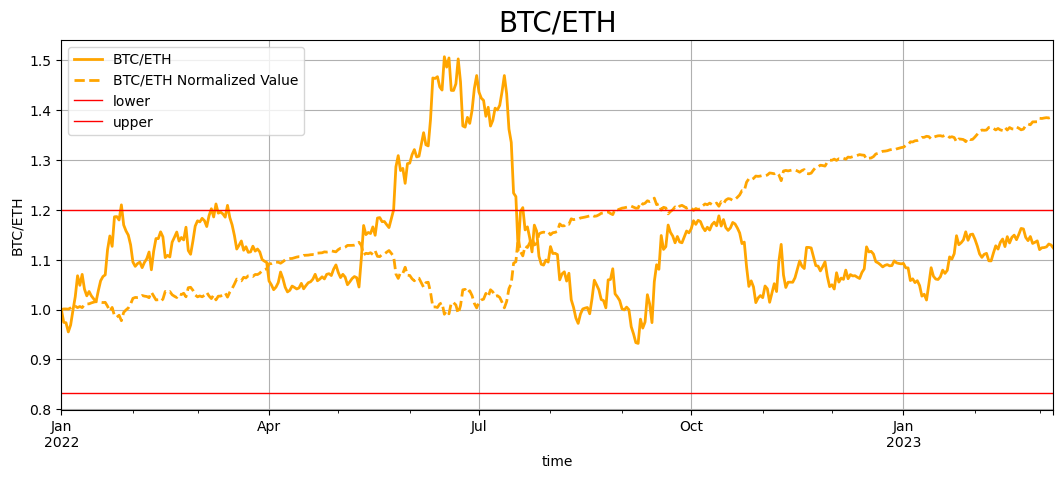

In [4]:
import matplotlib.pyplot as plt

metric_linestyles = {
    'AdrBal1in10BCnt':'-',
    'AdrBal1in1BCnt':'--',
    'AdrBal1in100MCnt':'-.',    
    'AdrBal1in10MCnt':':',    
    'AdrBalUSD1MCnt':':',
    'AdrBalUSD10KCnt':'-.',
    'AdrBalUSD1KCnt':'--',    
    'AdrBalUSD100Cnt':'-',       
}
coin_colors = {
    'BTC':'orange',
    'ETH':'grey',
    'AAVE':'purple',
    'LTC':'lightblue',
    'MKR':'lightgreen',
    'MATICETH':'blue',
    'BAL':'brown',
    'CRV': 'red',
    'ETC' : 'lightgreen',
    'ADA':'teal',
    'LINK' : 'darkblue',
    'XRP' : 'black',
    'XLM' : 'grey',
    'ALGO' : 'green',
    'BTG' : 'gold',
    'BAL' : 'brown',
    'SUSHI': 'magenta',
    'COMP' : 'green',
    'DOGE': 'brown',
    'BAT': 'crimson',
    'MANA': 'deeppink',
    '1INCH': 'hotpink',
    'ZEC': 'darkgrey',
    'YFI' : 'darkorange',
    'UNI': 'pink'
    
}
coin_max_supply = {
    'BTC': 21000000,
    'ETH': 122373866, # total supply as of 2023.01.01
    'AAVE':16000000,
    'LTC': 84000000,
    'MKR': 1005577,
    'MATICETH': 10000000000, # MATIC on ETH chan only
    'UNI':1000000000,
    'LDO':1000000000,
    'BAL': 96150704,
    'CRV': 3303030299,
    'ETC' : 210000000,
    'ADA': 45000000000,
    'BIFI' :80000,
    'LINK' : 1000000000,
    'XRP' : 100* 1000000000,
    'XLM' : 50001806812,
    'ALGO' : 10*1000000000,
    'BTG' : 21000000,
    'SUSHI': 250000000,
    'COMP' : 10000000,
    'DOGE': 132670764300, # total supply as of 2023.01.01
    'BAT': 1500000000,
    'MANA': 2193539027, # total supply as of 2023.01.01
    '1INCH': 1500000000,
    'ZEC': 21000000,
    'YFI' : 36666
    
}

F = plt.gcf()
DefaultSize = F.get_size_inches()

plt.title("BTC/ETH", fontsize=20)
plt.ylabel("BTC/ETH")
#for metric in metrics:
#    for coin in coins: 
df=df['2017-06-01':]

for pair in coin_pairs:
    df[pair[0]][pair[1]]['norm_price'][liquidity_submission_date:].plot(c=coin_colors[pair[0]],label=''+pair[0]+'/'+pair[1],linewidth=2)
    df[pair[0]][pair[1]]['norm_value'][liquidity_submission_date:].plot(c=coin_colors[pair[0]],label=''+pair[0]+'/'+pair[1] + ' Normalized Value',linewidth=2, ls = '--')

df[coin_pairs[0][0]][coin_pairs[0][1]]['norm_lower_liqidity_range'][liquidity_submission_date:].plot(c='red',label='lower',linewidth=1)
df[coin_pairs[0][0]][coin_pairs[0][1]]['norm_upper_liqidity_range'][liquidity_submission_date:].plot(c='red',label='upper',linewidth=1)
    
plt.grid()
plt.legend(loc='upper left')
#plt.ylim((0,25000))
F.set_size_inches( (DefaultSize[0]*2, DefaultSize[1]*1) )

